### Monte-Carlo-Simulation und Quantilband-Darstellung

In diesem Skript werden die Auswirkungen unterschiedlicher Erkrankungsraten (15 %, 30 %, 50 %, 70 %) mithilfe einer Monte-Carlo-Simulation untersucht.  
Für die Modellparameter (Konsultationsanteil, Hospitalisierungs- und Todesrate) werden **Dreiecksverteilungen** mit vorgegebenem Minimal-, Wahrscheinlichkeits- und Maximalwert angenommen.

Aus den Simulationen (n = 200.000) werden die **Quantile q05, q25, q50 (Median), q75 und q95** berechnet und grafisch als **Quantilband** dargestellt:
- dünne Linie: 90 %-Bereich (q05–q95),
- breiter Balken: mittlere 50 %-Masse (q25–q75),
- senkrechte Linie: Median (q50).

Die Darstellung dient ausschließlich der **Einordnung der Streuung und Unsicherheit** der Ergebnisse und ersetzt keine deterministische Referenzrechnung.

---

### ▶️ Ausführen des Programms

- Klicken Sie in die Code-Zelle.
- Drücken Sie `Shift + Enter`, um die Berechnung zu starten.  
  Alternativ können Sie auch auf **▶ Run** oben in der Werkzeugleiste klicken. 
- Über **Run → Run all cells** werden alle Zellen auf einmal ausgeführt.

---

In [58]:
import numpy as np
import pandas as pd

# =============================================================
# Eingaben
#==============================================================

pop = 100_000  # Angaben je ... Einwohner
n = 200_000

attack_rates = [0.15, 0.30, 0.50,0.70]

tri = dict(
    consult_frac=(0.45, 0.50, 0.55),
    hosp_per_consult=(0.024, 0.027, 0.030),
    death_per_consult=(0.004, 0.007, 0.010),
)

rng = np.random.default_rng(42)

#===========================================================
# Berechnungen - Monte-Carlo-Simulation (Dreiecksverteilung)
# ==========================================================

records = []

for ar in attack_rates:
    cf = rng.triangular(*tri["consult_frac"], size=n)
    hp = rng.triangular(*tri["hosp_per_consult"], size=n)
    dp = rng.triangular(*tri["death_per_consult"], size=n)

    ill = pop * ar
    consult = ill * cf
    hosp = consult * hp
    deaths = consult * dp

    df_ar = pd.DataFrame({
        "attack_rate": ar,
        "ill_total": ill,
        "consult_total": consult,
        "hosp_total": hosp,
        "deaths_total": deaths,
    })

    records.append(df_ar)

# DAS ist das gesuchte Objekt
sim = pd.concat(records, ignore_index=True)


In [59]:
# Definition des Plots

from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from figure_style import (
    TITLE_SIZE,
    SUBTITLE_SIZE,
    PAD_TITLE,
    PAD_SUBTITLE,
    TOP_RECT,
)

"""
Zentrale Stilkonstanten für Abbildungen
(analog zu einer .sty-Datei in LaTeX)
"""


def fmt_tri(tri: tuple[float, float, float], decimals: int = 3) -> str:
    a, m, b = tri
    def dc(x: float) -> str:
        return f"{x:.{decimals}f}".replace(".", ",")
    return f"{dc(a)} / {dc(m)} / {dc(b)}"


#def title_over_axes(fig, ax, *, title, subtitle=None,
#                    title_size=12, subtitle_size=10,
#                    pad_title=0.020, pad_subtitle=0.02):
 #   bbox = ax.get_position()
 #   x = bbox.x0 + bbox.width / 2
 #   y = bbox.y1 + pad_title
 #   fig.text(x, y, title, ha="center", va="bottom", fontsize=title_size)
 #   if subtitle:
 #       fig.text(x, y - pad_subtitle, subtitle, ha="center", va="bottom", fontsize=subtitle_size)

def title_over_axes(
    fig,
    ax,
    *,
    title: str,
    subtitle: str | None = None,          # ← bleibt für alte Aufrufe
    subtitles: list[str] | None = None,   # ← neu
    #pad_title: float = 0.02,
    #pad_subtitle: float = 0.015,
):
    """
    Einheitliche Titel-Hierarchie über einer Achse:
    - title: Haupttitel
    - subtitle: eine Subtitel-Zeile (legacy)
    - subtitles: mehrere Subtitel-Zeilen (neu, bevorzugt)
    """

    bbox = ax.get_position()
    x = bbox.x0 + bbox.width / 2
    y = bbox.y1 + PAD_TITLE

    # Haupttitel
    fig.text(
        x, y,
        title,
        ha="center", va="bottom",
        fontsize=TITLE_SIZE,
    )

    # Subtitel: neue Variante
    if subtitles:
        for i, line in enumerate(subtitles, start=1):
            fig.text(
                x,
                y - i * PAD_SUBTITLE,
                line,
                ha="center", va="bottom",
                fontsize=SUBTITLE_SIZE,
            )

    # Subtitel: alte Variante (nur wenn subtitles nicht gesetzt)
    elif subtitle:
        fig.text(
            x,
            y - PAD_SUBTITLE,
            subtitle,
            ha="center", va="bottom",
            fontsize=SUBTITLE_SIZE,
        )

def hist_with_quantile_band(
    df: pd.DataFrame,
    *,
    attack_rate: float,
    value_col: str,
    label: str,
    bins: int = 60,
    # optional: Annahmenzeile
    tri: tuple[float, float, float] | None = None,
    tri_label: str | None = None,
    norm_label: str | None = None,
    # Quantile (amtlich)
    qs: tuple[float, float, float, float, float] = (0.05, 0.25, 0.50, 0.75, 0.95),
    # Ausgabe
    show: bool = True,
    outpath: Path | None = None,
    # Layout
    top_rect: float = 0.86,
    pad_title: float = 0.120,
    pad_subtitle: float = 0.08,
):
    """
    Histogramm (relative Häufigkeit) + Quantilband-Streifen (unten).
    Der Streifen zeigt q05–q95 (90%-Spannweite), q25–q75 (mittlere 50%), Median.
    """

    s = df.loc[df["attack_rate"] == attack_rate, value_col]
    if s.empty:
        raise ValueError(f"Keine Daten für attack_rate={attack_rate} (value_col={value_col})")

    x = s.to_numpy()

    fig, (ax_hist, ax_band) = plt.subplots(
        nrows=2,
        figsize=(7, 5),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 1]},
    )

    # Histogramm: relative Häufigkeit
    weights = np.ones_like(x) / x.size
    ax_hist.hist(x, bins=bins, weights=weights, edgecolor="black")
    ax_hist.set_ylabel("Relative Häufigkeit", fontsize=11)
    ax_hist.tick_params(labelsize=10)

    # Quantile
    q05, q25, q50, q75, q95 = np.quantile(x, qs)

    # Quantilband-Streifen: keine y-Achse (nur „Skalenleiste“)
    ax_band.set_yticks([])
    ax_band.set_ylabel("")
    ax_band.set_xlabel("Personen", fontsize=11)
    ax_band.tick_params(labelsize=10)
    ax_band.set_ylim(0, 1)

    y = 0.5

    # q05..q95 (dünn)
    ax_band.hlines(y, q05, q95, linewidth=1, color="black")
    ax_band.vlines([q05, q95], y - 0.10, y + 0.10, linewidth=1.0, color="black")

    # q25..q75 (dick)
    ax_band.hlines(y, q25, q75, linewidth=7, color="gray")

    # Median
    ax_band.vlines(q50, y - 0.18, y + 0.18, linewidth=1.5, color="black")

    # Layout fixieren, dann Titel
    fig.tight_layout(rect=[0.04, 0.04, 0.98, TOP_RECT])

    main_title = f"{label} (Erkrankungsrate: {int(round(attack_rate*100))}%)"
    
    subtitles = []
    # 1) Normierung / Bezug
    if norm_label:
        subtitles.append(norm_label)   # z.B. "Angaben je 100.000 Einwohner"
    
    # 2) Annahmezeile
    if tri is not None and tri_label is not None:
        subtitles.append(f"{tri_label}: {fmt_tri(tri)}")
    
    title_over_axes(
        fig, 
        ax_hist,
        title=main_title,
        subtitles=subtitles,
    )

    if outpath is not None:
        outpath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return None #fig


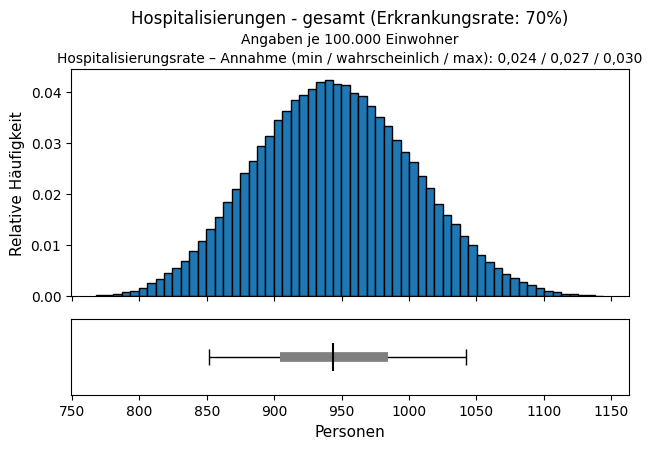

In [60]:
# Hospitalisierungen, show=True,  (AR=70%)

#outdir = Path("outputs/figures/Hist_Quantil")

hist_with_quantile_band(
    sim,
    attack_rate=0.70,
    value_col="hosp_total",
    label="Hospitalisierungen - gesamt",
    bins=60,
    tri=(0.024, 0.027, 0.030),
    norm_label="Angaben je 100.000 Einwohner",
    tri_label="Hospitalisierungsrate – Annahme (min / wahrscheinlich / max)",
    show=True,
    #outpath=outdir / "hosp_total_AR_70_hist_quantileband.pdf",
)

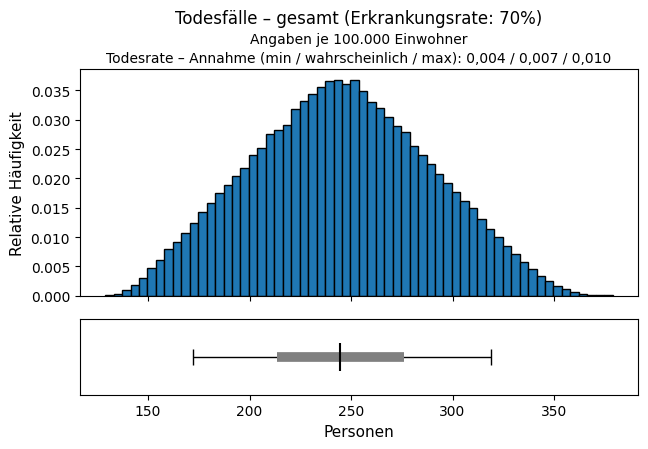

In [61]:
# Todesfälle (AR=70%), show=True,  (AR=70%)

#outdir = Path("outputs/figures/Hist_-Quantil")

hist_with_quantile_band(
    sim,
    attack_rate=0.70,
    value_col="deaths_total",
    label="Todesfälle – gesamt",
    bins=60,
    tri=(0.004, 0.007, 0.010),
    norm_label="Angaben je 100.000 Einwohner",
    tri_label="Todesrate – Annahme (min / wahrscheinlich / max)",
    show=True,
   # outpath=outdir / "deaths_total_AR_70_hist_quantileband.pdf",
)

 >Dargestellt sind der 90%-Bereich (q05–q95), der mittlere 50%-Bereich (q25–q75) und der Median (q50).